In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [2]:
#定义变量 
thermal_power_station_strategy=np.zeros(shape=(4,1000)) 
wind_power_station_strategy=np.zeros(shape=(2,1000))
c_wind_speed= np.loadtxt("./data/c_wind_speed_uniform_distribution_(3,25).txt")      
kappa_wind_speed= np.loadtxt("./data/kappa_wind_speed_uniform_distribution_(2,3).txt")  
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt") #时变的需求侧用电需求  阶梯式变化 
thermal_power_station_dual_variable=np.zeros(shape=(4,1000))
wind_power_station_dual_variable=np.zeros(shape=(2,1000))#两个风力发电站中有一个是受到拜占庭攻击的 假设第二个风力发电站是受到攻击的
E=np.loadtxt("6_Network_Topology_Double_Random_Adjacency_Matrix.txt")
thermal_power_station_cost=np.zeros(shape=(1,1000)) #火力发电成本
wind_power_station_cost=np.zeros(shape=(1,1000)) #风力发电成本
sum_cost=np.zeros(shape=(1,1000)) #总发电成本
#thermal_power_station_eta=[0.0375,0.0375,0.0625,0.035]
thermal_power_station_eta=[0.0675,0.0675,0.0925,0.0625]
thermal_power_station_zeta=[2,1.75,1,3]
thermal_power_station_xi=[0,0,0,0]
thermal_power_station_P_min=[50,20,15,10]
thermal_power_station_P_max=[200,120,80,100]
#wind_power_station_varphi=[3,6]
wind_power_station_varphi=[1,6]
wind_power_station_v_in=[3,5]
wind_power_station_v_out=[25,25]
wind_power_station_v_r=[13,15]
wind_power_station_sigma_ue=[5,5]
wind_power_station_sigma_oe=[30,20]
wind_power_station_P_r=[160,160]
wind_power_station_P_min=[0,0]
wind_power_station_P_max=[160,160]
sum_thermal_wind_power_station_strategy=np.zeros(shape=(1,1000))
step_size_primal=1
step_size_dual=1
regularization_parameter=0.001

In [3]:
#火力，风力发电策略初始化
thermal_power_station_strategy[0][0]=0
thermal_power_station_strategy[1][0]=0
thermal_power_station_strategy[2][0]=0
thermal_power_station_strategy[3][0]=0
wind_power_station_strategy[0][0]=0
wind_power_station_strategy[1][0]=0
#初始总发电策略
sum_thermal_wind_power_station_strategy[0][0]=0
#初始化受到攻击的风力发电站的对偶变量
wind_power_station_dual_variable[1][0]=-0.01

#安全发电站的初始总发电成本
#火力发电成本
for i in range(0,4):
    thermal_power_station_cost[0][0]=thermal_power_station_cost[0][0]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][0]*thermal_power_station_strategy[i][0]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][0]
#风力发电成本
for i in range(0,1):
    wind_power_station_cost[0][0]=wind_power_station_cost[0][0]+wind_power_station_varphi[i]*wind_power_station_strategy[i][0]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_r[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][0])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][0])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0]))))+(wind_power_station_P_r[i]*c_wind_speed[0]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[0],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][0])/wind_power_station_P_r[i],kappa_wind_speed[0]))/(math.pow(c_wind_speed[0],kappa_wind_speed[0])))*sc.gamma(1+1/kappa_wind_speed[0])-sc.gammaincc(1+1/kappa_wind_speed[0],math.pow(wind_power_station_v_in[i]/c_wind_speed[0],kappa_wind_speed[0]))*sc.gamma(1+1/kappa_wind_speed[0])))
#发电总成本
sum_cost[0][0]=thermal_power_station_cost[0][0]+wind_power_station_cost[0][0]


In [4]:
def Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual):
    #显示初始化的数据
    #输出初始状态的原变量和对偶变量
    print("***************************attack_free_online_decentralized_economic_dispatch*****************************")
    print("相关变量初始值为：")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始计划发电量为:",thermal_power_station_strategy[i][0])
    for i in range (0,2):
        print("第",(i+5),"个风力发电站的初始计划发电量为:",wind_power_station_strategy[i][0])
    print("****************************************************************************")
    for i in range (0,4):
        print("第",(i+1),"个火力发电站的初始对偶变量为:",thermal_power_station_dual_variable[i][0])
    for i in range (0,1):
        print("第",(i+5),"个风力发电站的初始对偶变量为:",wind_power_station_dual_variable[i][0])
    print("****************************************************************************")
    print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][0])
    print("****************************************************************************")
    print("安全发电站的初始总发电量:",sum_thermal_wind_power_station_strategy[0][0])
    print("*************************")
    print("需求侧平均用电需求:",d_power_demand[0])
    print("****************************************************************************")
    print("风速分布参数c:",c_wind_speed[0])
    print("****************************************************************************")
    print("风速分布参数kappa:",kappa_wind_speed[0])
    print("****************************************************************************")
    print("安全发电站的总发电成本：", sum_cost[0][0])
    print("****************************************************************************")
    print("原变量迭代步长为:",step_size_primal)
    print("*****************************************************************************")
    print("对偶变量迭代步长为:",step_size_dual)
    print("*****************************************************************************")
    
    #开始迭代
    for k in range(1,1000):
        #发电站更新计划发电量和对偶变量
        #对偶变量 先做梯度上升 再做聚合
        #安全发电站的梯度上升
        dual_variable_intermediate=[] #存放当前迭代中6个用户对对偶变量做完梯度下降后得到的中间值
        for i in range(0,4):
            dual_variable_intermediate.append(thermal_power_station_dual_variable[i][k-1]+step_size_dual*((1/6)*thermal_power_station_strategy[i][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*thermal_power_station_dual_variable[i][k-1]))
        for j in range(0,1):
            dual_variable_intermediate.append(wind_power_station_dual_variable[j][k-1]+step_size_dual*((1/6)*wind_power_station_strategy[j][k-1]-(1/6)*d_power_demand[k-1]-regularization_parameter*wind_power_station_dual_variable[j][k-1]))
        #受到攻击的风力发电站的对偶值
        dual_variable_intermediate.append(wind_power_station_dual_variable[1][k-1])
        #聚合 安全的火力发电站的对偶更新
        for i in range(0,4):
            weight_aggregation_dual_variable=0
            for j in range(0,4):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j]*dual_variable_intermediate[j]               
            for j in range(0,2):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i][j+4]*dual_variable_intermediate[j+4]
            thermal_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        #聚合 安全的风力发电站的对偶更新
        for i in range(0,1):
            weight_aggregation_dual_variable=0
            for j in range(0,4):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+4][j]*dual_variable_intermediate[j]               
            for j in range(0,2):
                weight_aggregation_dual_variable=weight_aggregation_dual_variable+E[i+4][j+4]*dual_variable_intermediate[j+4]
            wind_power_station_dual_variable[i][k]=weight_aggregation_dual_variable
        #受到Byzantine攻击的风力发电站的对偶更新
        wind_power_station_dual_variable[1][k]=wind_power_station_dual_variable[1][k-1]            
        
        #安全的火力发电站计划发电量
        for i in range(0,4):
            thermal_power_station_strategy[i][k]=thermal_power_station_strategy[i][k-1]-step_size_primal*(2*thermal_power_station_eta[i]*thermal_power_station_strategy[i][k-1]+thermal_power_station_zeta[i]+(1/6)*thermal_power_station_dual_variable[i][k-1]) 
            if thermal_power_station_strategy[i][k]<=thermal_power_station_P_min[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_min[i]
            elif thermal_power_station_strategy[i][k]>=thermal_power_station_P_max[i]:
                thermal_power_station_strategy[i][k]=thermal_power_station_P_max[i]
        #安全的风力发电站计划发电量
        for i in range(0,1):
            wind_power_station_strategy[i][k]=wind_power_station_strategy[i][k-1]-step_size_primal*(wind_power_station_varphi[i]+wind_power_station_sigma_oe[i]+(wind_power_station_sigma_ue[i]+wind_power_station_sigma_oe[i])*math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(-wind_power_station_sigma_ue[i]-wind_power_station_sigma_oe[i])*math.exp(-(math.pow((wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k-1])/wind_power_station_P_r[i]),kappa_wind_speed[k-1]))/(math.pow(c_wind_speed[k-1],kappa_wind_speed[k-1])))+(1/6)*wind_power_station_dual_variable[i][k-1])
            if wind_power_station_strategy[i][k]<=wind_power_station_P_min[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_min[i]
            elif wind_power_station_strategy[i][k]>=wind_power_station_P_max[i]:
                wind_power_station_strategy[i][k]=wind_power_station_P_max[i]
        #受到Byzantine攻击的风力发电站的计划发电量
        wind_power_station_strategy[1][k]=wind_power_station_strategy[1][k-1]
        
        #安全发电站的计算总计划发电
        #火力发电量
        for i in range(0,4):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+thermal_power_station_strategy[i][k]
        #风力发电量
        for i in range(0,1):
            sum_thermal_wind_power_station_strategy[0][k]=sum_thermal_wind_power_station_strategy[0][k]+wind_power_station_strategy[i][k]
        
        #安全发电站的计算总发电成本
        #火力发电成本
        for i in range(0,4):
            thermal_power_station_cost[0][k]=thermal_power_station_cost[0][k]+thermal_power_station_eta[i]*thermal_power_station_strategy[i][k]*thermal_power_station_strategy[i][k]+thermal_power_station_zeta[i]*thermal_power_station_strategy[i][k]
        #风力发电成本
        for i in range(0,1):
            wind_power_station_cost[0][k]=wind_power_station_cost[0][k]+wind_power_station_varphi[i]*wind_power_station_strategy[i][k]+wind_power_station_sigma_ue[i]*((wind_power_station_P_r[i]-wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_r[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))+wind_power_station_sigma_oe[i]*((wind_power_station_strategy[i][k])*(1-math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))+math.exp(-(math.pow(wind_power_station_v_out[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*wind_power_station_v_in[i]/(wind_power_station_v_r[i]-wind_power_station_v_in[i])+wind_power_station_strategy[i][k])*(math.exp(-(math.pow(wind_power_station_v_in[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))-math.exp(-(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k]))))+(wind_power_station_P_r[i]*c_wind_speed[k]/(wind_power_station_v_r[i]-wind_power_station_v_in[i]))*(sc.gammaincc(1+1/kappa_wind_speed[k],(math.pow(wind_power_station_v_in[i]+((wind_power_station_v_r[i]-wind_power_station_v_in[i])*wind_power_station_strategy[i][k])/wind_power_station_P_r[i],kappa_wind_speed[k]))/(math.pow(c_wind_speed[k],kappa_wind_speed[k])))*sc.gamma(1+1/kappa_wind_speed[k])-sc.gammaincc(1+1/kappa_wind_speed[k],math.pow(wind_power_station_v_in[i]/c_wind_speed[k],kappa_wind_speed[k]))*sc.gamma(1+1/kappa_wind_speed[k])))
        #发电总成本
        sum_cost[0][k]=thermal_power_station_cost[0][k]+wind_power_station_cost[0][k]
        
        #输出第k次迭代中的结果 每间隔10次迭代输出一次结果
        #if (k+1)%10==0:
        print(k,"次迭代中的结果：")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的计划发电量为:",thermal_power_station_strategy[i][k])
        for i in range (0,2):
            print("第",(i+5),"个风力发电站的计划发电量为:",wind_power_station_strategy[i][k])
        print("****************************************************************************")
        for i in range (0,4):
            print("第",(i+1),"个火力发电站的对偶变量为:",thermal_power_station_dual_variable[i][k])
        for i in range (0,1):
            print("第",(i+5),"个风力发电站的对偶变量为:",wind_power_station_dual_variable[i][k])
        print("****************************************************************************")
        print("第",(6),"个受到Byzantin攻击的风力发电站的初始对偶变量为:",wind_power_station_dual_variable[1][k])
        print("****************************************************************************")
        print("安全发电站的总发电量:",sum_thermal_wind_power_station_strategy[0][k])
        print("*************************")
        print("需求侧平均用电需求:",d_power_demand[k])
        print("****************************************************************************")
        print("风速分布参数c:",c_wind_speed[k])
        print("****************************************************************************")
        print("风速分布参数kappa:",kappa_wind_speed[k])
        print("****************************************************************************")        
        print("安全发电站的总发电成本：", sum_cost[0][k])
        print("****************************************************************************")
        print("原变量迭代步长为:",step_size_primal)
        print("****************************************************************************")
        print("对偶变量迭代步长为:",step_size_dual)
        print("****************************************************************************")
        
        #step_size_primal=(pow(k+1,0.1))
        #step_size_dual=1/(pow(k+1,0.7))#我们发现在在线算法中 不能使用太小的对偶步长 不然后续算法对在线变化会不敏感 
        
        '''#尝试使用两阶段的步长
        if k<=500:
            step_size_dual=1/(pow(k+1,0.7))
        else:
            step_size_dual=0.1'''

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')[:-3])
    return None  

In [5]:
Byzantine_attack_decentralized_economic_dispatch(thermal_power_station_strategy,wind_power_station_strategy,c_wind_speed,kappa_wind_speed,d_power_demand,thermal_power_station_dual_variable,wind_power_station_dual_variable,E,thermal_power_station_cost,wind_power_station_cost,thermal_power_station_eta,thermal_power_station_zeta,thermal_power_station_P_min,thermal_power_station_P_max,wind_power_station_varphi,wind_power_station_sigma_ue,wind_power_station_sigma_oe,wind_power_station_P_min,wind_power_station_P_max,sum_thermal_wind_power_station_strategy,step_size_primal,step_size_dual)

***************************attack_free_online_decentralized_economic_dispatch*****************************
相关变量初始值为：
第 1 个火力发电站的初始计划发电量为: 0.0
第 2 个火力发电站的初始计划发电量为: 0.0
第 3 个火力发电站的初始计划发电量为: 0.0
第 4 个火力发电站的初始计划发电量为: 0.0
第 5 个风力发电站的初始计划发电量为: 0.0
第 6 个风力发电站的初始计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的初始对偶变量为: 0.0
第 2 个火力发电站的初始对偶变量为: 0.0
第 3 个火力发电站的初始对偶变量为: 0.0
第 4 个火力发电站的初始对偶变量为: 0.0
第 5 个风力发电站的初始对偶变量为: 0.0
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的初始总发电量: 0.0
*************************
需求侧平均用电需求: 72.62781256
****************************************************************************
风速分布参数c: 8.301041
****************************************************************************
风速分布参数kappa: 2.66836324
****************************************************************************
安全发

第 5 个风力发电站的计划发电量为: 56.39848587110753
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -57.28730674068585
第 2 个火力发电站的对偶变量为: -43.71883723202168
第 3 个火力发电站的对偶变量为: -43.634459288469095
第 4 个火力发电站的对偶变量为: -33.029874442629904
第 5 个风力发电站的对偶变量为: -57.344146665726896
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 203.88274069980193
*************************
需求侧平均用电需求: 75.70722657
****************************************************************************
风速分布参数c: 7.5123474
****************************************************************************
风速分布参数kappa: 2.84390111
****************************************************************************
安全发电站的总发电成本： 1283.6342246069223
****************************************************************************
原变量迭代步长为: 1
*******

安全发电站的总发电成本： 1117.5167014192548
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
52 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 33.156225556950005
第 3 个火力发电站的计划发电量为: 28.004603030537794
第 4 个火力发电站的计划发电量为: 14.917001589337719
第 5 个风力发电站的计划发电量为: 38.950486884905345
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -50.88541033659948
第 2 个火力发电站的对偶变量为: -39.05396096651696
第 3 个火力发电站的对偶变量为: -38.981724356435315
第 4 个火力发电站的对偶变量为: -29.673501866989564
第 5 个风力发电站的对偶变量为: -51.122044458249235
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 165.02831706173086
************

第 4 个火力发电站的对偶变量为: -27.849927524868757
第 5 个风力发电站的对偶变量为: -44.27608697759345
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 187.2260298275723
*************************
需求侧平均用电需求: 64.9389132
****************************************************************************
风速分布参数c: 21.19086743
****************************************************************************
风速分布参数kappa: 2.91787133
****************************************************************************
安全发电站的总发电成本： 1353.1031647367554
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
75 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 32.31636343093546
第 3 个火力发电站的计划发电量为

第 5 个风力发电站的对偶变量为: -53.455220649828725
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 182.82318668959718
*************************
需求侧平均用电需求: 71.06400795
****************************************************************************
风速分布参数c: 8.01570786
****************************************************************************
风速分布参数kappa: 2.55306897
****************************************************************************
安全发电站的总发电成本： 1120.0927646126204
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
97 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.29746375107837
第 2 个火力发电站的计划发电量为: 35.717734099090016
第 3 个火力发电站的计划发电量为: 30.39027750576039
第 

第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -51.11544226446998
第 2 个火力发电站的对偶变量为: -39.461932212949044
第 3 个火力发电站的对偶变量为: -39.39404738706907
第 4 个火力发电站的对偶变量为: -30.637533806292016
第 5 个风力发电站的对偶变量为: -51.13761852740309
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 153.97843532459822
*************************
需求侧平均用电需求: 66.20271192
****************************************************************************
风速分布参数c: 6.64278269
****************************************************************************
风速分布参数kappa: 2.48532032
****************************************************************************
安全发电站的总发电成本： 921.7768782024914
****************************************************************************
原变量迭代步长为: 1
*********************************************

第 3 个火力发电站的计划发电量为: 30.581166457149344
第 4 个火力发电站的计划发电量为: 16.72581497848975
第 5 个风力发电站的计划发电量为: 53.52539215862108
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -50.73707133724533
第 2 个火力发电站的对偶变量为: -38.93880394189207
第 3 个火力发电站的对偶变量为: -38.85525756775201
第 4 个火力发电站的对偶变量为: -29.85157940359268
第 5 个风力发电站的对偶变量为: -50.703354862098166
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 187.58673855948723
*************************
需求侧平均用电需求: 68.31510475
****************************************************************************
风速分布参数c: 15.37789351
****************************************************************************
风速分布参数kappa: 2.72422256
****************************************************************************
安全发电站的总发电成本： 1150.5213019370694
*********************

****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
157 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.79709403044431
第 2 个火力发电站的计划发电量为: 35.61086394488323
第 3 个火力发电站的计划发电量为: 30.14215129838102
第 4 个火力发电站的计划发电量为: 16.019794691221154
第 5 个风力发电站的计划发电量为: 40.76234753104147
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -57.333029362161234
第 2 个火力发电站的对偶变量为: -43.81891953333168
第 3 个火力发电站的对偶变量为: -43.74299765594331
第 4 个火力发电站的对偶变量为: -33.05366638249012
第 5 个风力发电站的对偶变量为: -57.540752952109244
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 173.3322514959712
*************************
需求侧平均用电需求: 77.42644768
***************************************************************************

第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 200.9296213644909
*************************
需求侧平均用电需求: 72.51637663
****************************************************************************
风速分布参数c: 19.31530004
****************************************************************************
风速分布参数kappa: 2.17845277
****************************************************************************
安全发电站的总发电成本： 1418.1632626428627
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
181 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 35.17390831693724
第 3 个火力发电站的计划发电量为: 29.284374127900318
第 4 个火力发电站的计划发电量为: 16.44689604564421
第 5 个风力发电站的计划发电量为: 70.22038955888564
第 6 个风力发电站的计划发电量为: 0.0
********************************

第 2 个火力发电站的对偶变量为: -37.85221854022485
第 3 个火力发电站的对偶变量为: -37.78184672019018
第 4 个火力发电站的对偶变量为: -29.84867306032407
第 5 个风力发电站的对偶变量为: -48.63891860781932
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 188.86519449777754
*************************
需求侧平均用电需求: 75.02718188
****************************************************************************
风速分布参数c: 24.62352899
****************************************************************************
风速分布参数kappa: 2.8594221
****************************************************************************
安全发电站的总发电成本： 1586.0245394841263
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
206 次迭代中的结果：
第 1

第 2 个火力发电站的对偶变量为: -33.80343155583163
第 3 个火力发电站的对偶变量为: -33.73828467079355
第 4 个火力发电站的对偶变量为: -27.47966380435565
第 5 个风力发电站的对偶变量为: -42.78102000354595
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 177.22267947708568
*************************
需求侧平均用电需求: 63.84237528
****************************************************************************
风速分布参数c: 16.97130803
****************************************************************************
风速分布参数kappa: 2.38360024
****************************************************************************
安全发电站的总发电成本： 1159.428276825416
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
228 次迭代中的结果：
第 1

第 5 个风力发电站的计划发电量为: 54.42890568344972
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -54.64952206577078
第 2 个火力发电站的对偶变量为: -41.89815063263357
第 3 个火力发电站的对偶变量为: -41.82641938674767
第 4 个火力发电站的对偶变量为: -32.036056506752075
第 5 个风力发电站的对偶变量为: -54.64830470367892
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 188.74725289803825
*************************
需求侧平均用电需求: 71.9258155
****************************************************************************
风速分布参数c: 21.58186155
****************************************************************************
风速分布参数kappa: 2.68064296
****************************************************************************
安全发电站的总发电成本： 1413.5804548006606
****************************************************************************
原变量迭代步长为: 1
********

第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 208.79825616313468
*************************
需求侧平均用电需求: 66.07166909
****************************************************************************
风速分布参数c: 3.98009145
****************************************************************************
风速分布参数kappa: 2.4445451
****************************************************************************
安全发电站的总发电成本： 2742.420920720935
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
271 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 31.892748859455626
第 3 个火力发电站的计划发电量为: 27.011694960744556
第 4 个火力发电站的计划发电量为: 14.975217441067228
第 5 个风力发电站的计划发电量为: 61.51317057077497
第 6 个风力发电站的计划发电量为: 0.0
********************************

****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
291 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 34.03786134304768
第 3 个火力发电站的计划发电量为: 29.311735414710377
第 4 个火力发电站的计划发电量为: 15.528335657766537
第 5 个风力发电站的计划发电量为: 51.90331612928658
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -52.62738552822077
第 2 个火力发电站的对偶变量为: -40.49262982021936
第 3 个火力发电站的对偶变量为: -40.42810144635447
第 4 个火力发电站的对偶变量为: -31.232300556491985
第 5 个风力发电站的对偶变量为: -52.61920081165542
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 180.7812485448112
*************************
需求侧平均用电需求: 65.97955767
****************************************************************************
风速分布参数c: 6.

第 4 个火力发电站的计划发电量为: 17.521032618032958
第 5 个风力发电站的计划发电量为: 60.721683485335106
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -50.5077562976695
第 2 个火力发电站的对偶变量为: -38.89652985555741
第 3 个火力发电站的对偶变量为: -38.80846401484221
第 4 个火力发电站的对偶变量为: -29.986484828717167
第 5 个风力发电站的对偶变量为: -50.50394045019537
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 199.04487164704898
*************************
需求侧平均用电需求: 75.93445757
****************************************************************************
风速分布参数c: 18.82350243
****************************************************************************
风速分布参数kappa: 2.73564398
****************************************************************************
安全发电站的总发电成本： 1315.6016354099488
**********************************************************

第 4 个火力发电站的计划发电量为: 14.429171284140255
第 5 个风力发电站的计划发电量为: 19.118543524147334
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -50.66320359805326
第 2 个火力发电站的对偶变量为: -39.249094017649085
第 3 个火力发电站的对偶变量为: -39.180141958561684
第 4 个火力发电站的对偶变量为: -30.433847554989217
第 5 个风力发电站的对偶变量为: -50.89369708545237
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 142.1497911960529
*************************
需求侧平均用电需求: 67.98992536
****************************************************************************
风速分布参数c: 17.14940026
****************************************************************************
风速分布参数kappa: 2.23356631
****************************************************************************
安全发电站的总发电成本： 1125.9327835083263
********************************************************

*************************
需求侧平均用电需求: 64.62446887
****************************************************************************
风速分布参数c: 11.11120269
****************************************************************************
风速分布参数kappa: 2.36074701
****************************************************************************
安全发电站的总发电成本： 1084.7777128333817
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
360 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 51.622758915828896
第 2 个火力发电站的计划发电量为: 37.368360270813994
第 3 个火力发电站的计划发电量为: 31.448498357559878
第 4 个火力发电站的计划发电量为: 16.688172040098426
第 5 个风力发电站的计划发电量为: 33.8811044064729
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -56.06508074549979
第 2 个火力发电站的对偶变量为: -42.49806458203499
第 3 个火力发电站的对

需求侧平均用电需求: 71.45041101
****************************************************************************
风速分布参数c: 7.53079924
****************************************************************************
风速分布参数kappa: 2.5195072
****************************************************************************
安全发电站的总发电成本： 1383.2628929608995
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
382 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 33.02798041095027
第 3 个火力发电站的计划发电量为: 27.54906697822308
第 4 个火力发电站的计划发电量为: 15.257005999475998
第 5 个风力发电站的计划发电量为: 59.5727498133429
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -46.1590782580921
第 2 个火力发电站的对偶变量为: -36.01904658598112
第 3 个火力发电站的对偶变量为: -35.9416089537713
第 4 个火力发电站的对偶变量为: -28

****************************************************************************
安全发电站的总发电成本： 1427.3135557876155
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
403 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 30.700844662504537
第 3 个火力发电站的计划发电量为: 26.332256062569797
第 4 个火力发电站的计划发电量为: 14.275952616123323
第 5 个风力发电站的计划发电量为: 62.702515533079605
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -46.826856849851275
第 2 个火力发电站的对偶变量为: -36.5913079406699
第 3 个火力发电站的对偶变量为: -36.530285889106885
第 4 个火力发电站的对偶变量为: -29.308871764040465
第 5 个风力发电站的对偶变量为: -46.68804827588464
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
*******************************************

第 1 个火力发电站的对偶变量为: -53.09756227098636
第 2 个火力发电站的对偶变量为: -40.68040235527574
第 3 个火力发电站的对偶变量为: -40.60822368660723
第 4 个火力发电站的对偶变量为: -31.059096193753117
第 5 个风力发电站的对偶变量为: -53.08649356786579
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 190.02033061918695
*************************
需求侧平均用电需求: 66.01198165
****************************************************************************
风速分布参数c: 18.6837591
****************************************************************************
风速分布参数kappa: 2.15087552
****************************************************************************
安全发电站的总发电成本： 1339.8460148954669
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
*******************************************************

第 2 个火力发电站的计划发电量为: 32.4826962748165
第 3 个火力发电站的计划发电量为: 27.522915713537817
第 4 个火力发电站的计划发电量为: 14.666349528437046
第 5 个风力发电站的计划发电量为: 57.59193393275405
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -45.46642473658531
第 2 个火力发电站的对偶变量为: -35.304801295854176
第 3 个火力发电站的对偶变量为: -35.23541703206144
第 4 个火力发电站的对偶变量为: -27.94185786113469
第 5 个风力发电站的对偶变量为: -45.285010745692965
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 182.2638954495454
*************************
需求侧平均用电需求: 69.57798272
****************************************************************************
风速分布参数c: 13.84325204
****************************************************************************
风速分布参数kappa: 2.40286654
****************************************************************************
安全发电站的总发电成本： 109

第 2 个火力发电站的对偶变量为: -37.64339887380266
第 3 个火力发电站的对偶变量为: -37.58609990734701
第 4 个火力发电站的对偶变量为: -29.536427619132105
第 5 个风力发电站的对偶变量为: -48.57041139437329
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 157.47468632582792
*************************
需求侧平均用电需求: 77.05803731
****************************************************************************
风速分布参数c: 20.18536968
****************************************************************************
风速分布参数kappa: 2.29156911
****************************************************************************
安全发电站的总发电成本： 1207.3288234640538
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
468 次迭代中的结果：
第

第 4 个火力发电站的对偶变量为: -29.650028203695907
第 5 个风力发电站的对偶变量为: -49.03032735147006
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 200.06519865560867
*************************
需求侧平均用电需求: 69.2540679
****************************************************************************
风速分布参数c: 11.2063798
****************************************************************************
风速分布参数kappa: 2.82765966
****************************************************************************
安全发电站的总发电成本： 1126.130601144853
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
492 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 36.494432708503375
第 3 个火力发电站的计划发电量

第 5 个风力发电站的对偶变量为: -52.05995669315236
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 176.80893238446018
*************************
需求侧平均用电需求: 68.10702103
****************************************************************************
风速分布参数c: 12.68723937
****************************************************************************
风速分布参数kappa: 2.76725837
****************************************************************************
安全发电站的总发电成本： 1065.8563007495102
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
512 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 34.76961034546746
第 3 个火力发电站的计划发电量为: 29.398191208343725
第 4 个火力发电站的计划发

第 4 个火力发电站的计划发电量为: 15.232675922417023
第 5 个风力发电站的计划发电量为: 57.112020615361175
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -46.58847103062984
第 2 个火力发电站的对偶变量为: -36.39544177314124
第 3 个火力发电站的对偶变量为: -36.32356428367115
第 4 个火力发电站的对偶变量为: -29.219315614072524
第 5 个风力发电站的对偶变量为: -46.32415306207939
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 183.49898831209737
*************************
需求侧平均用电需求: 73.50300904
****************************************************************************
风速分布参数c: 15.11619255
****************************************************************************
风速分布参数kappa: 2.05761227
****************************************************************************
安全发电站的总发电成本： 1190.667435728463
**********************************************************

第 3 个火力发电站的计划发电量为: 27.839389637629324
第 4 个火力发电站的计划发电量为: 14.916547138938775
第 5 个风力发电站的计划发电量为: 49.07936648268528
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -48.6253705529824
第 2 个火力发电站的对偶变量为: -37.6985610245482
第 3 个火力发电站的对偶变量为: -37.629290658353526
第 4 个火力发电站的对偶变量为: -29.429693198591846
第 5 个风力发电站的对偶变量为: -48.69051030942495
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 174.63869083160978
*************************
需求侧平均用电需求: 69.4614233
****************************************************************************
风速分布参数c: 21.66700794
****************************************************************************
风速分布参数kappa: 2.25746493
****************************************************************************
安全发电站的总发电成本： 1352.113707826652
***********************

****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
576 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 35.52179738400253
第 3 个火力发电站的计划发电量为: 30.01221995363489
第 4 个火力发电站的计划发电量为: 16.909967081149013
第 5 个风力发电站的计划发电量为: 72.49129257362279
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -50.2825647862113
第 2 个火力发电站的对偶变量为: -38.99875690923595
第 3 个火力发电站的对偶变量为: -38.922641810937584
第 4 个火力发电站的对偶变量为: -30.784601040397078
第 5 个风力发电站的对偶变量为: -50.0577959945765
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 204.9352769924092
*************************
需求侧平均用电需求: 65.04147277
*

风速分布参数c: 9.17295648
****************************************************************************
风速分布参数kappa: 2.41246226
****************************************************************************
安全发电站的总发电成本： 1332.0823159496463
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
598 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 34.79701506878564
第 3 个火力发电站的计划发电量为: 29.327431085941846
第 4 个火力发电站的计划发电量为: 15.978054943526267
第 5 个风力发电站的计划发电量为: 69.41758990432255
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -49.51937739908251
第 2 个火力发电站的对偶变量为: -38.62213438687833
第 3 个火力发电站的对偶变量为: -38.54624602379057
第 4 个火力发电站的对偶变量为: -30.895929668414187
第 5 个风力发电站的对偶变量为: -49.242408211067456
****************************************

风速分布参数c: 24.38503034
****************************************************************************
风速分布参数kappa: 2.86093013
****************************************************************************
安全发电站的总发电成本： 1244.325311696557
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
621 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 33.483472659852694
第 3 个火力发电站的计划发电量为: 28.593835555633156
第 4 个火力发电站的计划发电量为: 15.882273704373642
第 5 个风力发电站的计划发电量为: 23.933647303239628
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -51.220846633568705
第 2 个火力发电站的对偶变量为: -39.336946001114065
第 3 个火力发电站的对偶变量为: -39.26930638931076
第 4 个火力发电站的对偶变量为: -29.865254904816492
第 5 个风力发电站的对偶变量为: -51.50851665770833
*************************************

第 2 个火力发电站的对偶变量为: -35.60067831567918
第 3 个火力发电站的对偶变量为: -35.52128280517747
第 4 个火力发电站的对偶变量为: -28.51103439842597
第 5 个风力发电站的对偶变量为: -45.34775114438608
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 208.18633121930867
*************************
需求侧平均用电需求: 75.89494443
****************************************************************************
风速分布参数c: 15.99773894
****************************************************************************
风速分布参数kappa: 2.03929034
****************************************************************************
安全发电站的总发电成本： 1350.4336078532233
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
644 次迭代中的结果：
第 

第 4 个火力发电站的计划发电量为: 17.045977773406193
第 5 个风力发电站的计划发电量为: 53.22339557686303
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -56.56306644576189
第 2 个火力发电站的对偶变量为: -43.143610550685636
第 3 个火力发电站的对偶变量为: -43.07583296309216
第 4 个火力发电站的对偶变量为: -32.61201115796853
第 5 个风力发电站的对偶变量为: -56.59750835681873
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 191.13990922431566
*************************
需求侧平均用电需求: 76.23188942
****************************************************************************
风速分布参数c: 24.17871322
****************************************************************************
风速分布参数kappa: 2.48384611
****************************************************************************
安全发电站的总发电成本： 1559.8785062625925
**********************************************************

第 1 个火力发电站的对偶变量为: -44.64956348499687
第 2 个火力发电站的对偶变量为: -35.01944289215535
第 3 个火力发电站的对偶变量为: -34.952937708204445
第 4 个火力发电站的对偶变量为: -28.376390762802398
第 5 个风力发电站的对偶变量为: -44.40237342818662
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 169.11296728571162
*************************
需求侧平均用电需求: 73.06634732
****************************************************************************
风速分布参数c: 15.39915562
****************************************************************************
风速分布参数kappa: 2.29436735
****************************************************************************
安全发电站的总发电成本： 1106.2809399996686
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
*****************************************************

第 3 个火力发电站的对偶变量为: -39.73566417750119
第 4 个火力发电站的对偶变量为: -30.545370180154865
第 5 个风力发电站的对偶变量为: -51.82656265644671
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 150.88144966280845
*************************
需求侧平均用电需求: 74.34925141
****************************************************************************
风速分布参数c: 13.60295391
****************************************************************************
风速分布参数kappa: 2.27578955
****************************************************************************
安全发电站的总发电成本： 1118.4170398545518
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
706 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发

第 5 个风力发电站的计划发电量为: 46.2769543171056
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -48.292403213446434
第 2 个火力发电站的对偶变量为: -37.40328713190593
第 3 个火力发电站的对偶变量为: -37.32306892700697
第 4 个火力发电站的对偶变量为: -29.25919902267469
第 5 个风力发电站的对偶变量为: -48.256811494471776
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 173.61022385753546
*************************
需求侧平均用电需求: 69.23971082
****************************************************************************
风速分布参数c: 23.02100073
****************************************************************************
风速分布参数kappa: 2.96976859
****************************************************************************
安全发电站的总发电成本： 1378.7417583077556
****************************************************************************
原变量迭代步长为: 1
*******

需求侧平均用电需求: 65.16536174
****************************************************************************
风速分布参数c: 15.7646609
****************************************************************************
风速分布参数kappa: 2.67731095
****************************************************************************
安全发电站的总发电成本： 1204.4146133778709
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
748 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 51.690686027375826
第 2 个火力发电站的计划发电量为: 37.572121774668716
第 3 个火力发电站的计划发电量为: 31.393298334605156
第 4 个火力发电站的计划发电量为: 17.1157131604877
第 5 个风力发电站的计划发电量为: 67.02317135880341
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -49.511664130058264
第 2 个火力发电站的对偶变量为: -38.03273296860638
第 3 个火力发电站的对偶变量为: -37.94717073574966
第 

第 3 个火力发电站的对偶变量为: -41.94462165983566
第 4 个火力发电站的对偶变量为: -31.388881807268124
第 5 个风力发电站的对偶变量为: -55.41417401084349
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 174.0265189549539
*************************
需求侧平均用电需求: 66.24382228
****************************************************************************
风速分布参数c: 22.82052892
****************************************************************************
风速分布参数kappa: 2.97476202
****************************************************************************
安全发电站的总发电成本： 1377.3271794998882
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
771 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 51.32832857385637
第 

对偶变量迭代步长为: 1
****************************************************************************
800 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 34.59226332243072
第 3 个火力发电站的计划发电量为: 29.287098204878678
第 4 个火力发电站的计划发电量为: 15.660005950273465
第 5 个风力发电站的计划发电量为: 21.223201085498868
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -52.19318410465701
第 2 个火力发电站的对偶变量为: -39.884505656531616
第 3 个火力发电站的对偶变量为: -39.81085596873642
第 4 个火力发电站的对偶变量为: -29.83622596988195
第 5 个风力发电站的对偶变量为: -52.571601574060324
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 150.76256856308171
*************************
需求侧平均用电需求: 57.37428656
****************************************************************************
风速分布参数c: 18.5460696
*****************************************************************

第 2 个火力发电站的计划发电量为: 30.01245554486229
第 3 个火力发电站的计划发电量为: 25.039228134988498
第 4 个火力发电站的计划发电量为: 13.318259384829027
第 5 个风力发电站的计划发电量为: 59.4014976286978
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -43.18515598549146
第 2 个火力发电站的对偶变量为: -33.84467626288211
第 3 个火力发电站的对偶变量为: -33.7734215264218
第 4 个火力发电站的对偶变量为: -27.142517034046595
第 5 个风力发电站的对偶变量为: -43.15955535387594
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 177.7714406933776
*************************
需求侧平均用电需求: 76.24139333
****************************************************************************
风速分布参数c: 18.35707468
****************************************************************************
风速分布参数kappa: 2.11956095
****************************************************************************
安全发电站的总发电成本： 1253.

第 5 个风力发电站的计划发电量为: 61.13497325618181
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -43.206242459964
第 2 个火力发电站的对偶变量为: -33.91375220843112
第 3 个火力发电站的对偶变量为: -33.850652937669864
第 4 个火力发电站的对偶变量为: -27.39352135614432
第 5 个风力发电站的对偶变量为: -43.0965135307281
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 180.6019934084788
*************************
需求侧平均用电需求: 63.44963678
****************************************************************************
风速分布参数c: 19.20385531
****************************************************************************
风速分布参数kappa: 2.49701844
****************************************************************************
安全发电站的总发电成本： 1247.1401978343115
****************************************************************************
原变量迭代步长为: 1
***********

风速分布参数kappa: 2.95216133
****************************************************************************
安全发电站的总发电成本： 1074.3917050415992
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
865 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 29.2103095875105
第 3 个火力发电站的计划发电量为: 25.08822238510011
第 4 个火力发电站的计划发电量为: 12.901947624558446
第 5 个风力发电站的计划发电量为: 69.51886594324087
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -43.980565474780946
第 2 个火力发电站的对偶变量为: -34.61646665609237
第 3 个火力发电站的对偶变量为: -34.558650350210385
第 4 个火力发电站的对偶变量为: -28.15233967552533
第 5 个风力发电站的对偶变量为: -43.83479253224181
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
***********************

第 1 个火力发电站的对偶变量为: -53.98232666740502
第 2 个火力发电站的对偶变量为: -41.4360104110894
第 3 个火力发电站的对偶变量为: -41.367058591376605
第 4 个火力发电站的对偶变量为: -31.65672446358457
第 5 个风力发电站的对偶变量为: -54.08088051036722
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 172.7946183280419
*************************
需求侧平均用电需求: 72.84245786
****************************************************************************
风速分布参数c: 10.90389066
****************************************************************************
风速分布参数kappa: 2.62088506
****************************************************************************
安全发电站的总发电成本： 1051.0020317971757
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
********************************************************

第 4 个火力发电站的对偶变量为: -27.1939094613975
第 5 个风力发电站的对偶变量为: -41.69133879534053
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 186.19419400213843
*************************
需求侧平均用电需求: 73.11797973
****************************************************************************
风速分布参数c: 15.35164019
****************************************************************************
风速分布参数kappa: 2.25462541
****************************************************************************
安全发电站的总发电成本： 1159.9930437503103
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
902 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.0
第 2 个火力发电站的计划发电量为: 31.60282472574197
第 3 个火力发电站的计划发电量

第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -47.29141791291809
第 2 个火力发电站的对偶变量为: -36.83272964496104
第 3 个火力发电站的对偶变量为: -36.76267710939672
第 4 个火力发电站的对偶变量为: -29.37476893240365
第 5 个风力发电站的对偶变量为: -47.03454100768853
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 203.37390159512157
*************************
需求侧平均用电需求: 66.36067078
****************************************************************************
风速分布参数c: 8.60313232
****************************************************************************
风速分布参数kappa: 2.47756525
****************************************************************************
安全发电站的总发电成本： 1365.646741608252
****************************************************************************
原变量迭代步长为: 1
***********************************************

第 3 个火力发电站的对偶变量为: -40.91768749466159
第 4 个火力发电站的对偶变量为: -31.694860333509787
第 5 个风力发电站的对偶变量为: -53.15821623839744
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 196.74926003123926
*************************
需求侧平均用电需求: 66.75439241
****************************************************************************
风速分布参数c: 9.95819171
****************************************************************************
风速分布参数kappa: 2.60402706
****************************************************************************
安全发电站的总发电成本： 1161.2611979567014
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
940 次迭代中的结果：
第 1 个火力发电站的计划发电量为: 50.90893797956782
第 

第 4 个火力发电站的计划发电量为: 16.51109387491376
第 5 个风力发电站的计划发电量为: 32.03942711674524
第 6 个风力发电站的计划发电量为: 0.0
****************************************************************************
第 1 个火力发电站的对偶变量为: -50.9288972337615
第 2 个火力发电站的对偶变量为: -39.06622519930336
第 3 个火力发电站的对偶变量为: -38.98817645399762
第 4 个火力发电站的对偶变量为: -29.876495382514587
第 5 个风力发电站的对偶变量为: -50.94071327804508
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 164.0974557092838
*************************
需求侧平均用电需求: 66.64252831
****************************************************************************
风速分布参数c: 24.2478588
****************************************************************************
风速分布参数kappa: 2.50449403
****************************************************************************
安全发电站的总发电成本： 1331.5248474867558
**************************************************************

第 2 个火力发电站的对偶变量为: -39.24615768779235
第 3 个火力发电站的对偶变量为: -39.15706996291703
第 4 个火力发电站的对偶变量为: -30.284695890967743
第 5 个风力发电站的对偶变量为: -50.915722996893
****************************************************************************
第 6 个受到Byzantin攻击的风力发电站的初始对偶变量为: -0.01
****************************************************************************
安全发电站的总发电量: 172.87262346795652
*************************
需求侧平均用电需求: 72.23682768
****************************************************************************
风速分布参数c: 22.51345686
****************************************************************************
风速分布参数kappa: 2.97387863
****************************************************************************
安全发电站的总发电成本： 1370.6858939760828
****************************************************************************
原变量迭代步长为: 1
****************************************************************************
对偶变量迭代步长为: 1
****************************************************************************
985 次迭代中的结果：
第 1

In [6]:
#数据存储
np.savetxt('./data/01_large_Byzantine_attack_sum_cost.txt',sum_cost,fmt='%0.8f')
np.savetxt('./data/01_large_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt',sum_thermal_wind_power_station_strategy,fmt='%0.8f')

In [7]:
#评价指标：动态regret和累计的约束违反

In [8]:
#动态regret

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [10]:
sum_cost=np.loadtxt("./data/01_large_Byzantine_attack_sum_cost.txt")
optimal_sum_cost=np.loadtxt("./data/00_optimal_sum_cost_varying_D_c_kappa_normal_distribution_(70,5).txt")

In [11]:
dynamic_regret=[]
dynamic_regret_T=[]
for T in range(1, 1000):
    dynamic_regret_auxiliary_variable=0
    for t in range(0, T):
        dynamic_regret_auxiliary_variable=dynamic_regret_auxiliary_variable+sum_cost[t+1]-optimal_sum_cost[t+1]
    dynamic_regret.append(dynamic_regret_auxiliary_variable)
    dynamic_regret_T.append((dynamic_regret_auxiliary_variable)/T)

In [12]:
dynamic_regret

[-1203.6743223,
 -2916.3363546,
 -4769.46612144,
 -6102.25427715,
 -7783.39484024,
 -9104.56950673,
 -10715.52198519,
 -12170.27339903,
 -13341.16141104,
 -16062.52552056,
 -17789.84909495,
 -18872.572009980002,
 -20470.7378383,
 -21807.99003076,
 -22816.57291249,
 -24368.03571261,
 -25370.661865379996,
 -27249.087737719994,
 -28428.904034239993,
 -30309.171038969995,
 -31583.437338169995,
 -33247.15895485,
 -34625.7645928,
 -36740.972362479995,
 -37552.689716819994,
 -39152.72281652999,
 -40888.81130853999,
 -42137.32386069999,
 -43911.40981067999,
 -45179.48363932999,
 -46332.36434028999,
 -47648.49563410999,
 -49008.89948875999,
 -50287.99441861,
 -51278.444735619996,
 -52290.55764573,
 -53615.50029323,
 -53955.49897466,
 -54669.03744293,
 -55995.06838522,
 -57070.85774791,
 -58368.65702237,
 -59375.70154973,
 -60622.44796143,
 -61769.45634687,
 -62806.38267451,
 -63815.3049056,
 -65357.85792142,
 -66784.01189593,
 -68564.18078144999,
 -69434.80927504,
 -71436.42248824,
 -72537.8224

In [28]:
math.log(abs(dynamic_regret[998]),2)

20.295857636676494

In [13]:
dynamic_regret_T

[-1203.6743223,
 -1458.1681773,
 -1589.8220404800002,
 -1525.5635692875,
 -1556.6789680480001,
 -1517.4282511216668,
 -1530.788855027143,
 -1521.28417487875,
 -1482.3512678933334,
 -1606.252552056,
 -1617.2590086318182,
 -1572.714334165,
 -1574.6721414076924,
 -1557.7135736257144,
 -1521.1048608326666,
 -1523.002232038125,
 -1492.3918744341174,
 -1513.8382076511107,
 -1496.2581070652627,
 -1515.4585519484997,
 -1503.9732065795235,
 -1511.2344979477273,
 -1505.468025773913,
 -1530.8738484366665,
 -1502.1075886727997,
 -1505.8739544819227,
 -1514.4004188348144,
 -1504.9044235964282,
 -1514.1865451958615,
 -1505.9827879776665,
 -1494.5923980738708,
 -1489.0154885659372,
 -1485.1181663260604,
 -1479.0586593708822,
 -1465.0984210177141,
 -1452.5154901591666,
 -1449.0675754927026,
 -1419.8815519647367,
 -1401.770190844359,
 -1399.8767096305,
 -1391.9721401929269,
 -1389.7299291040476,
 -1380.8302685983722,
 -1377.7829082143182,
 -1372.654585486,
 -1365.3561450980435,
 -1357.7724448000001,
 -

In [14]:
#绘图 dynamic_regret和dynamic_regret_T

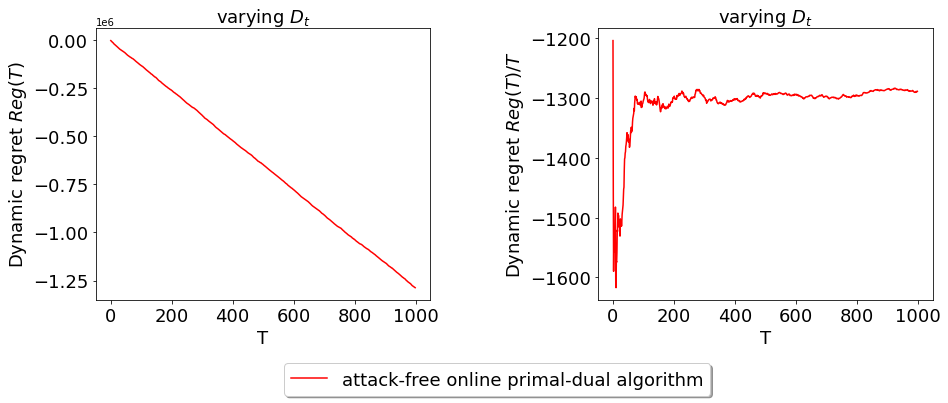

In [15]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,dynamic_regret_T,color = 'red',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Dynamic regret $Reg(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))

#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure1_dynamic_regret_attack_free_varying_D.png',format='png', bbox_inches='tight')

In [16]:
#累计的约束违反

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import *
import math 
from datetime import datetime
from scipy.special import gamma, factorial
import scipy.special as sc

In [18]:
sum_thermal_wind_power_station_strategy=np.loadtxt("./data/01_large_Byzantine_attack_sum_thermal_wind_power_station_strategy.txt")
d_power_demand=np.loadtxt("./data/d_power_demand_normal_distribution_(70,5).txt")

In [19]:
accumulative_constraint_violation=[]
accumulative_constraint_violation_T=[]
for T in range(1, 1000):
    accumulative_constraint_violation_auxiliary_variable=0
    for t in range(0, T): 
        accumulative_constraint_violation_auxiliary_variable=accumulative_constraint_violation_auxiliary_variable+(1/5)*sum_thermal_wind_power_station_strategy[t+1]-d_power_demand[t+1]
    accumulative_constraint_violation.append(abs(accumulative_constraint_violation_auxiliary_variable))
    accumulative_constraint_violation_T.append(abs(accumulative_constraint_violation_auxiliary_variable)/T)

In [20]:
accumulative_constraint_violation_T

[44.659041904000006,
 48.588688235000006,
 50.180749188,
 50.706155002500005,
 50.482212744,
 50.01957271433333,
 49.62112302885714,
 48.06305575125,
 47.21359925666666,
 47.912873743999995,
 47.860219790909085,
 46.59420465333333,
 45.92998104923076,
 45.480445030999995,
 44.47000864733333,
 43.851837423999996,
 43.63353276023529,
 43.41670213366667,
 42.65159337463158,
 42.4038839676,
 42.15315439152381,
 41.857210371272735,
 41.64790756373914,
 41.62919580691668,
 41.08076209984,
 41.07980877046154,
 41.111014055333335,
 40.762958427214286,
 40.56184532386207,
 40.11892282660001,
 39.65679782774195,
 39.67788684193751,
 39.42465517806061,
 39.203687938470594,
 38.78790770577143,
 38.50915152705556,
 38.30339247735135,
 37.64770561710527,
 37.32595285635898,
 37.1836689717,
 36.998309443317076,
 37.07553794409524,
 36.988797594744184,
 36.84766840313637,
 36.73190490053334,
 36.57875397304348,
 36.53471028382979,
 36.47004821170833,
 36.540774788571426,
 36.56819589448,
 36.556217913

In [21]:
#绘图 accumulative_constraint_violation和accumulative_constraint_violation_T

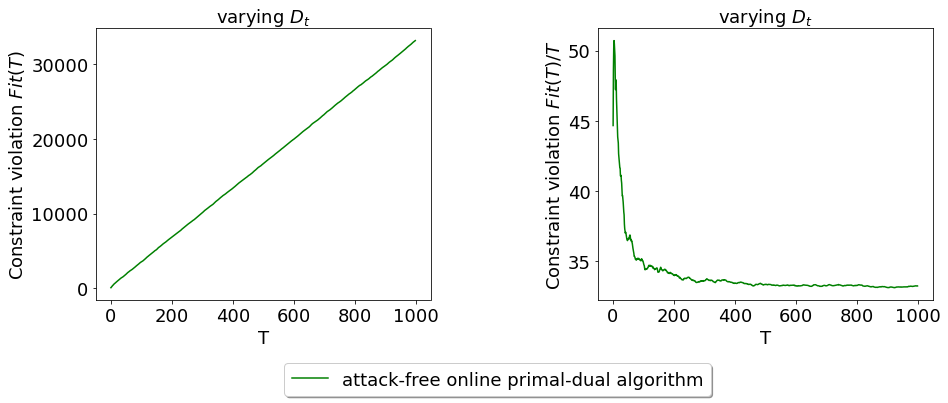

In [22]:
sub1=plt.subplot(1, 2, 1)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)$',font2)
plt.title('varying $D_{t}$',font2) 

sub2=plt.subplot(1, 2, 2)##############################################################
iteration=[]
for i in range(0,999):
    iteration.append(i)

#在同一幅图片上画3条折线
A,=plt.plot(iteration,accumulative_constraint_violation_T,color = 'green',linewidth = '1.5',label='attack-free online primal-dual algorithm')


#设置图例并且设置图例的字体及大小
font1 = {
'size'   : 18,
}
#legend = plt.legend(handles=[A],prop=font1)
 
#设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=18)
 
#设置横纵坐标的名称以及对应字体格式
font2 = {
'size'   : 18,
}
plt.xlabel('T',font2)
plt.ylabel(r'Constraint violation $Fit(T)/T$',font2)
plt.title('varying $D_{t}$',font2) 

plt.legend(handles=[A],prop={'size':18},loc="upper center", bbox_to_anchor=[-0.3, -0.2],
           ncol=18, shadow=True, fancybox=True)

plt.subplots_adjust(wspace=0.5,hspace=0.5) 
plt.gcf().set_size_inches((15, 5))


#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.pdf',format='pdf', bbox_inches='tight')
#plt.savefig('./figures/01-figure2_constraint_violation_attack_free_varying_D.png',format='png', bbox_inches='tight')